##Task 1

##Task 4.1

Device: cuda

Starting experiments for alpha = 0.05
Alpha=0.05 client sizes: [897, 726, 196, 1874, 1307]

Running mu=0.0 (FedProx if mu>0 else FedAvg baseline)
 Round 1/30 | mu=0.0 | avg_drift=2.0561e+00 | test_acc=0.2265
 Round 4/30 | mu=0.0 | avg_drift=2.7368e+00 | test_acc=0.3306
 Round 7/30 | mu=0.0 | avg_drift=2.2231e+00 | test_acc=0.4129
 Round 10/30 | mu=0.0 | avg_drift=1.8283e+00 | test_acc=0.3518
 Round 13/30 | mu=0.0 | avg_drift=2.0255e+00 | test_acc=0.3884
 Round 16/30 | mu=0.0 | avg_drift=1.5557e+00 | test_acc=0.4094
 Round 19/30 | mu=0.0 | avg_drift=1.3440e+00 | test_acc=0.4451
 Round 22/30 | mu=0.0 | avg_drift=1.3467e+00 | test_acc=0.4079
 Round 25/30 | mu=0.0 | avg_drift=1.8236e+00 | test_acc=0.3871
 Round 28/30 | mu=0.0 | avg_drift=1.3044e+00 | test_acc=0.4388
 Round 30/30 | mu=0.0 | avg_drift=1.1381e+00 | test_acc=0.4495

Running mu=0.001 (FedProx if mu>0 else FedAvg baseline)
 Round 1/30 | mu=0.001 | avg_drift=2.1364e+00 | test_acc=0.2389
 Round 4/30 | mu=0.001 | avg_

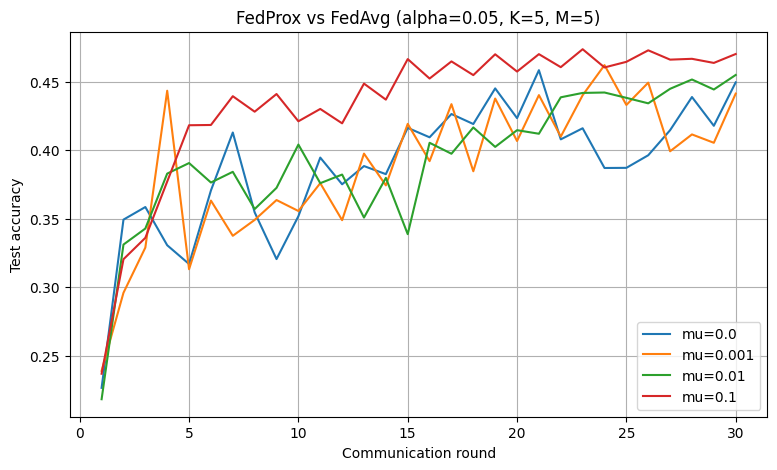

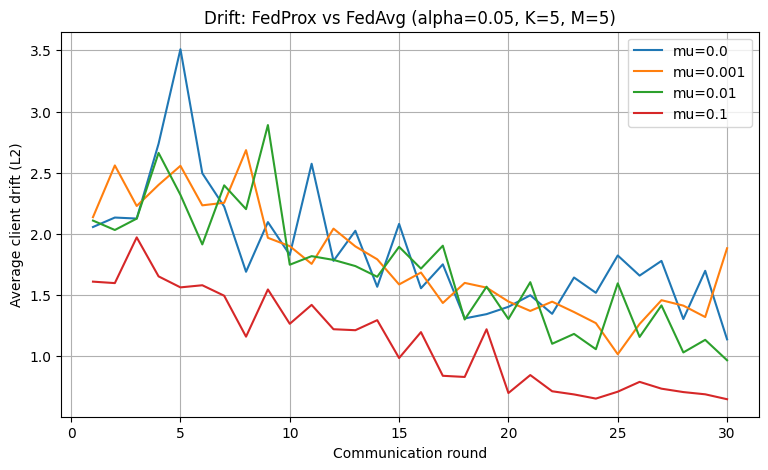

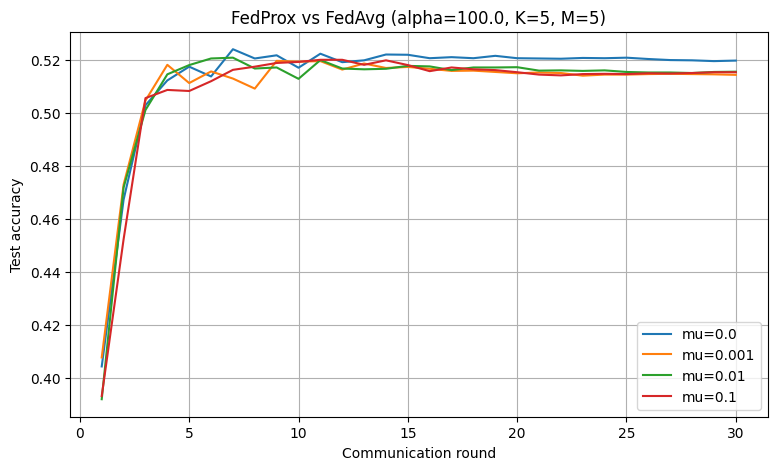

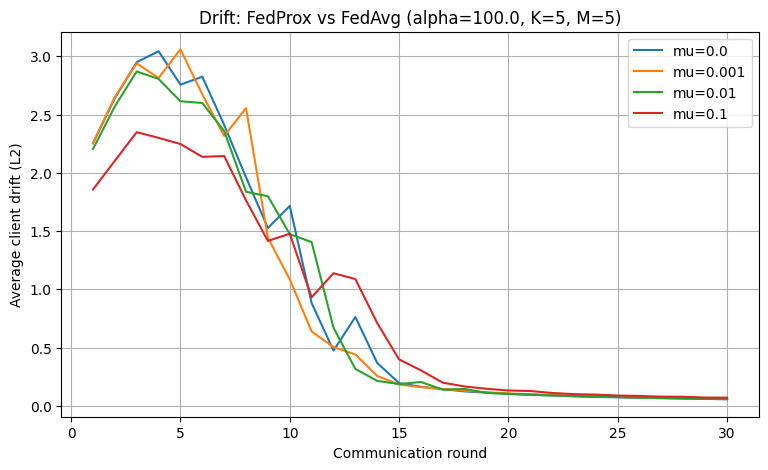


Summary (final accuracy and avg drift last 5 rounds):
alpha	mu	final_acc	avg_drift_last5	client_sizes
0.05	0.0	0.4495	1.5158e+00	[897, 726, 196, 1874, 1307]
0.05	0.001	0.4413	1.4677e+00	[897, 726, 196, 1874, 1307]
0.05	0.01	0.4549	1.1410e+00	[897, 726, 196, 1874, 1307]
0.05	0.1	0.4702	7.1407e-01	[897, 726, 196, 1874, 1307]
100.0	0.0	0.5199	6.3032e-02	[966, 983, 1034, 1012, 1005]
100.0	0.001	0.5145	6.8209e-02	[966, 983, 1034, 1012, 1005]
100.0	0.01	0.5157	6.3882e-02	[966, 983, 1034, 1012, 1005]
100.0	0.1	0.5155	7.6802e-02	[966, 983, 1034, 1012, 1005]

Saved figures to fedprox_results/


In [ ]:
# Colab-ready: FedProx experiments vs FedAvg baseline
# Paste into a Colab cell and run.
# Produces accuracy and drift plots comparing mu values (including mu=0 -> FedAvg)

!pip -q install torch torchvision --upgrade

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np, random, copy, math, os
import matplotlib.pyplot as plt
from tqdm import trange

# ===========================
# ========== CONFIG =========
# ===========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 12345
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

# Data / clients
M = 5                  # number of clients
total_samples = 5000   # total CIFAR-10 samples to use (subset)
ALPHAS = [0.05, 100.0] # two scenarios: skewed and near-IID (change as needed)

# Fed settings
K = 5                  # local epochs per round
ROUNDS = 30            # communication rounds
LOCAL_BS = 64
LR = 0.01
MOMENTUM = 0.9

# FedProx settings: include mu=0 for FedAvg baseline
MU_LIST = [0.0, 0.001, 0.01, 0.1]  # mu=0 is FedAvg; others are FedProx

# Misc
REPEATS = 1            # increase for averaging (keeps run simple by default)
SAVE_DIR = "fedprox_results"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Device:", DEVICE)

# ===========================
# ===== Data & model =======
# ===========================
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# subset indices for faster runs
all_indices = list(range(len(full_train)))
random.shuffle(all_indices)
subset_indices = all_indices[:total_samples]
subset_labels = [full_train[i][1] for i in subset_indices]

# small CNN
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*16*16,256)
        self.fc2 = nn.Linear(256,num_classes)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ===========================
# ===== Utils & helpers =====
# ===========================
def dirichlet_partition(labels, M, alpha, seed=None):
    # labels: numpy array of labels for the subset (length total_samples)
    if seed is not None:
        np.random.seed(seed); random.seed(seed)
    labels = np.array(labels)
    client_indices = [[] for _ in range(M)]
    C = labels.max() + 1
    for c in range(C):
        idx_c = np.where(labels == c)[0].tolist()
        if len(idx_c) == 0:
            continue
        np.random.shuffle(idx_c)
        props = np.random.dirichlet([alpha]*M)
        counts = np.random.multinomial(len(idx_c), props)
        cur = 0
        for j in range(M):
            cnt = counts[j]
            if cnt>0:
                client_indices[j].extend(idx_c[cur:cur+cnt])
            cur += cnt
    # convert subset-relative indices to absolute dataset indices
    client_abs = [[subset_indices[i] for i in idx_list] for idx_list in client_indices]
    return client_abs

def build_client_datasets(client_abs_indices):
    return [Subset(full_train, idxs) for idxs in client_abs_indices]

def get_param_tensors(model):
    return [p.data.clone().cpu() for p in model.parameters()]

def set_param_tensors(model, tensors):
    for p, t in zip(model.parameters(), tensors):
        p.data.copy_(t.to(p.device))

def param_l2_norm_diff(paramsA, paramsB):
    s = 0.0
    for a,b in zip(paramsA, paramsB):
        diff = (a - b).view(-1)
        s += float((diff*diff).sum().cpu())
    return math.sqrt(s)

def evaluate(model, loader, device):
    model.eval()
    correct = 0; total=0; loss_sum=0.0
    c = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss_sum += float(c(out,yb).item())
            preds = out.argmax(dim=1)
            correct += int((preds==yb).sum().item())
            total += yb.size(0)
    return loss_sum/total, correct/total

# ===========================
# ===== FedProx local step ==
# ===========================
def local_train_fedprox(client_model, loader, theta_global_tensors, K, optimizer, mu, device):
    # theta_global_tensors: list of cpu tensors (detached snapshot)
    theta_global_on_device = [t.to(device) for t in theta_global_tensors]
    client_model.train()
    for epoch in range(K):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = client_model(xb)
            data_loss = F.cross_entropy(out, yb)
            if mu > 0.0:
                prox = 0.0
                for p_local, p_global in zip(client_model.parameters(), theta_global_on_device):
                    prox = prox + (p_local - p_global).pow(2).sum()
                prox = 0.5 * mu * prox
                loss = data_loss + prox
            else:
                loss = data_loss
            loss.backward()
            optimizer.step()
    return get_param_tensors(client_model)

# ===========================
# ===== FedProx experiment ==
# ===========================
def run_one_experiment_for_alpha(alpha, mu_list, rounds=30, K=5, local_bs=64, lr=0.01, momentum=0.9, device=DEVICE, seed=SEED):
    # partition dataset with Dirichlet alpha
    client_abs = dirichlet_partition(np.array(subset_labels), M=M, alpha=alpha, seed=seed)
    client_sizes = [len(x) for x in client_abs]
    print(f"Alpha={alpha} client sizes: {client_sizes}")
    client_datasets = build_client_datasets(client_abs)
    test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

    # will store results for each mu
    results_mu = {}

    # Save a common initial state dict to ensure fair comparison across mu
    base_model = SmallCNN().to(device)
    init_state = copy.deepcopy(base_model.state_dict())

    for mu in mu_list:
        print(f"\nRunning mu={mu} (FedProx if mu>0 else FedAvg baseline)")
        # initialize global model
        global_model = SmallCNN().to(device)
        global_model.load_state_dict(init_state)

        # prepare client models (we'll load global for each client before local training)
        client_models = [SmallCNN().to(device) for _ in range(M)]
        for cm in client_models:
            cm.load_state_dict(init_state)

        client_loaders = [DataLoader(ds, batch_size=local_bs, shuffle=True) for ds in client_datasets]

        accs = []
        drifts = []

        for r in range(rounds):
            # snapshot of global params
            global_before = get_param_tensors(global_model)

            client_params_after = []
            client_N = []
            for i in range(M):
                # load global to client
                client_models[i].load_state_dict(global_model.state_dict())
                optimizer = optim.SGD(client_models[i].parameters(), lr=lr, momentum=momentum)
                # if client has no data, skip training
                if len(client_loaders[i].dataset) == 0:
                    client_params_after.append(get_param_tensors(client_models[i]))
                    client_N.append(0)
                    continue
                # local training with FedProx
                params_after = local_train_fedprox(client_models[i], client_loaders[i], global_before, K, optimizer, mu, device)
                client_params_after.append(params_after)
                client_N.append(len(client_loaders[i].dataset))

            # compute avg drift (only over clients with >0 samples)
            valid = [(p,s) for p,s in zip(client_params_after, client_N) if s>0]
            if len(valid)==0:
                avg_drift = 0.0
            else:
                drift_sum = 0.0
                for p,s in valid:
                    drift_sum += param_l2_norm_diff(p, global_before)
                avg_drift = drift_sum / len(valid)
            drifts.append(avg_drift)

            # aggregate weighted by Ni
            totalN = sum(client_N) if sum(client_N)>0 else 1
            new_global = [torch.zeros_like(p) for p in global_before]
            for params, Ni in zip(client_params_after, client_N):
                w = (Ni/totalN) if Ni>0 else 0.0
                for idx, p in enumerate(params):
                    new_global[idx] += w * p.to(new_global[idx].device)

            set_param_tensors(global_model, new_global)

            # evaluate
            g_loss, g_acc = evaluate(global_model, test_loader, device)
            accs.append(g_acc)

            # print progress occasionally
            if (r % max(1, rounds//10) == 0) or r == rounds-1:
                print(f" Round {r+1}/{rounds} | mu={mu} | avg_drift={avg_drift:.4e} | test_acc={g_acc:.4f}")

        results_mu[mu] = {'accs': accs, 'drift': drifts, 'client_sizes': client_sizes}

    return results_mu

# ===========================
# ======= Run experiments ===
# ===========================
all_results = {}
for alpha in ALPHAS:
    # run repeats if desired (here REPEATS=1)
    aggregated_for_alpha = {}
    print("\n" + "="*60)
    print(f"Starting experiments for alpha = {alpha}")
    for rep in range(REPEATS):
        seed_rep = SEED + rep
        res = run_one_experiment_for_alpha(alpha, MU_LIST, rounds=ROUNDS, K=K, local_bs=LOCAL_BS, lr=LR, momentum=MOMENTUM, device=DEVICE, seed=seed_rep)
        # accumulate per mu: we will average across repeats if REPEATS>1
        if rep == 0:
            for mu,v in res.items():
                aggregated_for_alpha.setdefault(mu, []).append(v)
        else:
            for mu,v in res.items():
                aggregated_for_alpha[mu].append(v)
    # compute mean over repeats (if REPEATS>1)
    mean_results = {}
    for mu, runs in aggregated_for_alpha.items():
        # runs is list of run dicts; each run has accs (list len ROUNDS) and drift
        accs = np.array([r['accs'] for r in runs])
        drifts = np.array([r['drift'] for r in runs])
        mean_acc = accs.mean(axis=0)
        std_acc = accs.std(axis=0)
        mean_drift = drifts.mean(axis=0)
        std_drift = drifts.std(axis=0)
        mean_results[mu] = {'mean_acc': mean_acc, 'std_acc': std_acc, 'mean_drift': mean_drift, 'std_drift': std_drift, 'client_sizes': runs[0]['client_sizes']}
    all_results[alpha] = mean_results

# ===========================
# ======= Plot results ======
# ===========================
for alpha, resdict in all_results.items():
    plt.figure(figsize=(9,5))
    for mu, v in sorted(resdict.items(), key=lambda x: x[0]):
        x = np.arange(1, ROUNDS+1)
        y = v['mean_acc']
        s = v['std_acc']
        plt.plot(x, y, label=f"mu={mu}")
        if REPEATS>1:
            plt.fill_between(x, y-s, y+s, alpha=0.2)
    plt.xlabel("Communication round")
    plt.ylabel("Test accuracy")
    plt.title(f"FedProx vs FedAvg (alpha={alpha}, K={K}, M={M})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"accuracy_alpha_{alpha}.png"))
    plt.show()

    plt.figure(figsize=(9,5))
    for mu, v in sorted(resdict.items(), key=lambda x: x[0]):
        x = np.arange(1, ROUNDS+1)
        y = v['mean_drift']
        s = v['std_drift']
        plt.plot(x, y, label=f"mu={mu}")
        if REPEATS>1:
            plt.fill_between(x, y-s, y+s, alpha=0.2)
    plt.xlabel("Communication round")
    plt.ylabel("Average client drift (L2)")
    plt.title(f"Drift: FedProx vs FedAvg (alpha={alpha}, K={K}, M={M})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"drift_alpha_{alpha}.png"))
    plt.show()

# ===========================
# ======= Summary table =====
# ===========================
print("\nSummary (final accuracy and avg drift last 5 rounds):")
print("alpha\tmu\tfinal_acc\tavg_drift_last5\tclient_sizes")
for alpha, resdict in all_results.items():
    for mu, v in sorted(resdict.items(), key=lambda x: x[0]):
        final_acc = v['mean_acc'][-1]
        avg_drift_last5 = v['mean_drift'][-5:].mean()
        sizes = v['client_sizes']
        print(f"{alpha}\t{mu}\t{final_acc:.4f}\t{avg_drift_last5:.4e}\t{sizes}")

print(f"\nSaved figures to {SAVE_DIR}/")


##Task 4.2


Device: cuda

Starting alpha = 0.05
Alpha=0.05 client sizes: [897, 726, 196, 1874, 1307]

=== Running method: fedavg ===
 Round 1/30 | method=fedavg | avg_drift=2.0559e+00 | test_acc=0.2269
 Round 4/30 | method=fedavg | avg_drift=2.7563e+00 | test_acc=0.3215
 Round 7/30 | method=fedavg | avg_drift=2.3541e+00 | test_acc=0.3983
 Round 10/30 | method=fedavg | avg_drift=1.8446e+00 | test_acc=0.3632
 Round 13/30 | method=fedavg | avg_drift=2.1045e+00 | test_acc=0.3737
 Round 16/30 | method=fedavg | avg_drift=1.5101e+00 | test_acc=0.4062
 Round 19/30 | method=fedavg | avg_drift=1.3882e+00 | test_acc=0.4383
 Round 22/30 | method=fedavg | avg_drift=1.3392e+00 | test_acc=0.4091
 Round 25/30 | method=fedavg | avg_drift=1.5872e+00 | test_acc=0.4108
 Round 28/30 | method=fedavg | avg_drift=1.3341e+00 | test_acc=0.4173
 Round 30/30 | method=fedavg | avg_drift=1.1371e+00 | test_acc=0.4383

=== Running method: scaffold ===
 Round 1/30 | method=scaffold | avg_drift=2.1440e+00 | test_acc=0.2389
 Round 

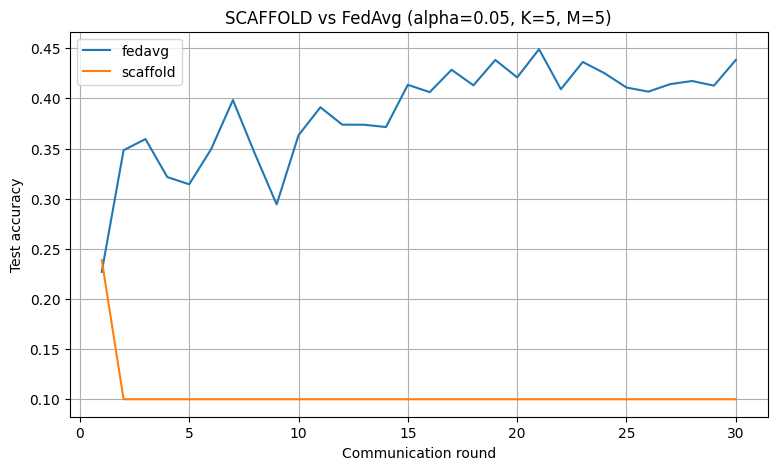

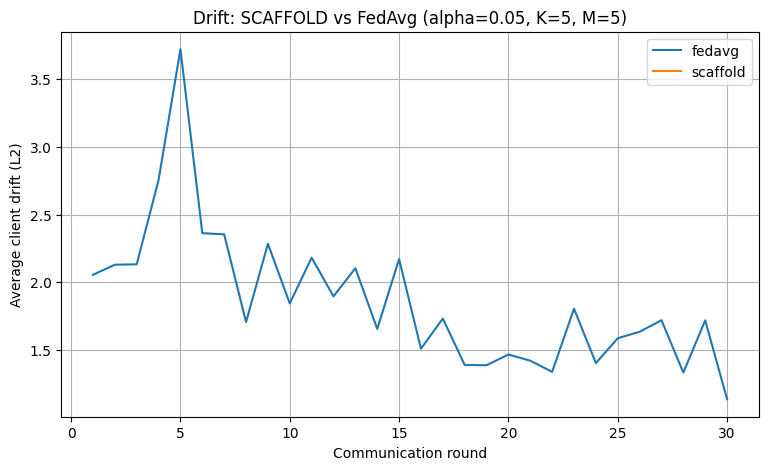

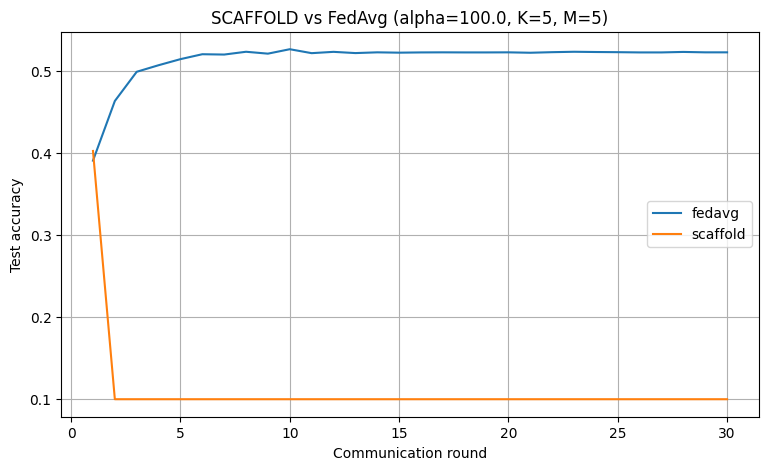

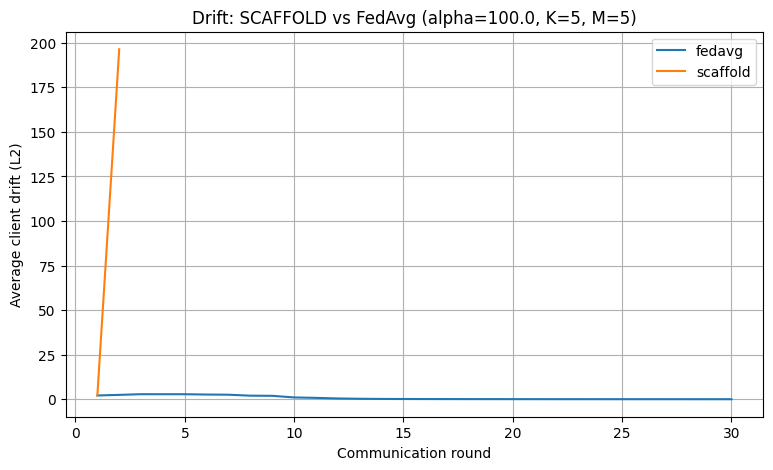


Summary (final accuracy and avg drift last 5 rounds):
alpha	method	final_acc	avg_drift_last5
0.05	fedavg	0.4383	1.5092e+00
0.05	scaffold	0.1000	nan
100.0	fedavg	0.5228	6.9118e-02
100.0	scaffold	0.1000	nan

Saved figures to scaffold_results/


In [ ]:
# Colab-ready: SCAFFOLD vs FedAvg comparison
# Paste into a Colab cell and run.

!pip -q install torch torchvision --upgrade

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np, random, copy, math, os
import matplotlib.pyplot as plt
from tqdm import trange

# ===========================
# ========== CONFIG =========
# ===========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 12345
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

# Data / clients
M = 5                  # number of clients
total_samples = 5000   # subset of CIFAR-10 for speed
ALPHAS = [0.05, 100.0] # Dirichlet alphas to try (skewed vs IID)

# Fed settings
K = 5                  # local epochs per round
ROUNDS = 30            # communication rounds
LOCAL_BS = 64
LR = 0.01
MOMENTUM = 0.9

# Methods to compare
METHODS = ['fedavg', 'scaffold']  # baseline and SCAFFOLD

# Repeats for averaging (set >1 to compute mean±std)
REPEATS = 1

SAVE_DIR = "scaffold_results"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Device:", DEVICE)

# ===========================
# ===== Data & model =======
# ===========================
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# subset selection
all_indices = list(range(len(full_train)))
random.shuffle(all_indices)
subset_indices = all_indices[:total_samples]
subset_labels = [full_train[i][1] for i in subset_indices]

# small CNN
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*16*16,256)
        self.fc2 = nn.Linear(256,num_classes)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ===========================
# ======= Helpers ==========
# ===========================
def dirichlet_partition(labels, M, alpha, seed=None):
    if seed is not None:
        np.random.seed(seed); random.seed(seed)
    labels = np.array(labels)
    client_indices = [[] for _ in range(M)]
    C = labels.max() + 1
    for c in range(C):
        idx_c = np.where(labels == c)[0].tolist()
        if len(idx_c) == 0:
            continue
        np.random.shuffle(idx_c)
        props = np.random.dirichlet([alpha]*M)
        counts = np.random.multinomial(len(idx_c), props)
        cur = 0
        for j in range(M):
            cnt = counts[j]
            if cnt>0:
                client_indices[j].extend(idx_c[cur:cur+cnt])
            cur += cnt
    # convert subset-relative to absolute dataset indices
    client_abs = [[subset_indices[i] for i in idx_list] for idx_list in client_indices]
    return client_abs

def build_client_datasets(client_abs_indices):
    return [Subset(full_train, idxs) for idxs in client_abs_indices]

def get_param_tensors(model):
    return [p.data.clone().cpu() for p in model.parameters()]

def set_param_tensors(model, tensors):
    for p, t in zip(model.parameters(), tensors):
        p.data.copy_(t.to(p.device))

def param_l2_norm_diff(paramsA, paramsB):
    s = 0.0
    for a,b in zip(paramsA, paramsB):
        diff = (a - b).view(-1)
        s += float((diff*diff).sum().cpu())
    return math.sqrt(s)

def evaluate(model, loader, device):
    model.eval()
    correct = 0; total=0; loss_sum=0.0
    c = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss_sum += float(c(out,yb).item())
            preds = out.argmax(dim=1)
            correct += int((preds==yb).sum().item())
            total += yb.size(0)
    return loss_sum/total, correct/total

# ===========================
# === Client local steps ====
# ===========================
def local_train_fedavg(client_model, loader, K, optimizer, device):
    client_model.train()
    for epoch in range(K):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = client_model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            optimizer.step()
    return get_param_tensors(client_model)

def local_train_scaffold(client_model, loader, K, optimizer, device, c_global_list, c_local_list):
    """
    c_global_list and c_local_list: lists of tensors (CPU), same length as model.parameters()
    We will add (c_local - c_global) to p.grad before optimizer.step()
    """
    client_model.train()
    # Move controls to device once per client
    c_global_on_device = [t.to(device) for t in c_global_list]
    c_local_on_device = [t.to(device) for t in c_local_list]
    for epoch in range(K):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = client_model(xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            # apply control correction to gradients: p.grad += (c_local - c_global)
            for p, cg, cli in zip(client_model.parameters(), c_global_on_device, c_local_on_device):
                if p.grad is None:
                    continue
                p.grad.data.add_( (cli - cg) )
            optimizer.step()
    return get_param_tensors(client_model)

# ===========================
# === Runner for methods ====
# ===========================
def run_methods_for_alpha(alpha, methods, rounds=ROUNDS, K=K, local_bs=LOCAL_BS, lr=LR, momentum=MOMENTUM, device=DEVICE, seed=SEED):
    client_abs = dirichlet_partition(np.array(subset_labels), M=M, alpha=alpha, seed=seed)
    client_sizes = [len(x) for x in client_abs]
    print(f"Alpha={alpha} client sizes: {client_sizes}")
    client_datasets = build_client_datasets(client_abs)
    client_loaders = [DataLoader(ds, batch_size=local_bs, shuffle=True) for ds in client_datasets]
    test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

    # initial common state
    base_model = SmallCNN().to(device)
    init_state = copy.deepcopy(base_model.state_dict())

    results = {m: {'accs': [], 'drift': []} for m in methods}

    for method in methods:
        print(f"\n=== Running method: {method} ===")
        # initialize global model
        global_model = SmallCNN().to(device)
        global_model.load_state_dict(init_state)

        # If SCAFFOLD, init controls
        if method == 'scaffold':
            # global control c: list of cpu tensors zeros
            c_global = [torch.zeros_like(p.data).cpu() for p in global_model.parameters()]
            # per-client local controls c_local[i]
            c_local = {i: [torch.zeros_like(p.data).cpu() for p in global_model.parameters()] for i in range(M)}
        else:
            c_global = None
            c_local = None

        # client model placeholders
        client_models = [SmallCNN().to(device) for _ in range(M)]
        for cm in client_models:
            cm.load_state_dict(init_state)

        for r in range(rounds):
            # snapshot global params before local updates (CPU)
            global_before = get_param_tensors(global_model)

            client_params_after = []
            client_N = []

            for i in range(M):
                # load global into client
                client_models[i].load_state_dict(global_model.state_dict())
                optimizer = optim.SGD(client_models[i].parameters(), lr=lr, momentum=momentum)

                # skip if no data
                if len(client_loaders[i].dataset) == 0:
                    client_params_after.append(get_param_tensors(client_models[i]))
                    client_N.append(0)
                    continue

                if method == 'fedavg':
                    params_after = local_train_fedavg(client_models[i], client_loaders[i], K, optimizer, device)
                elif method == 'scaffold':
                    # pass copies of current c_global and c_local[i] (CPU lists)
                    params_after = local_train_scaffold(client_models[i], client_loaders[i], K, optimizer, device, c_global, c_local[i])
                else:
                    raise ValueError("Unknown method")

                client_params_after.append(params_after)
                client_N.append(len(client_loaders[i].dataset))

                # After local training: update c_local for SCAFFOLD
                if method == 'scaffold':
                    theta_after = params_after
                    theta_before = global_before
                    # compute c_i_new = c_i_old - c_global + (1/(eta * K)) * (theta_before - theta_after)
                    factor = 1.0 / (lr * K)
                    # update on CPU
                    for j in range(len(c_local[i])):
                        delta = (theta_before[j] - theta_after[j])  # CPU tensors
                        c_local[i][j] = c_local[i][j] - c_global[j] + factor * delta

            # compute avg drift (only over clients with data)
            valid = [(p,s) for p,s in zip(client_params_after, client_N) if s>0]
            if len(valid) == 0:
                avg_drift = 0.0
            else:
                drift_sum = 0.0
                for p,s in valid:
                    drift_sum += param_l2_norm_diff(p, global_before)
                avg_drift = drift_sum / len(valid)
            results[method]['drift'].append(avg_drift)

            # Aggregate models weighted by Ni
            totalN = sum(client_N) if sum(client_N)>0 else 1
            new_global = [torch.zeros_like(p) for p in global_before]
            for params, Ni in zip(client_params_after, client_N):
                w = (Ni/totalN) if Ni>0 else 0.0
                for idx, p in enumerate(params):
                    new_global[idx] += w * p.to(new_global[idx].device)
            set_param_tensors(global_model, new_global)

            # Server updates c_global after collecting client c_local (for SCAFFOLD)
            if method == 'scaffold':
                # average new c_local across clients with data
                # note: c_local[i] already updated on CPU
                clients_with_data = [i for i,Ni in enumerate(client_N) if Ni>0]
                if len(clients_with_data) > 0:
                    new_c_global = [torch.zeros_like(c_local[clients_with_data[0]][j]) for j in range(len(c_local[clients_with_data[0]]))]
                    for i in clients_with_data:
                        for j in range(len(new_c_global)):
                            new_c_global[j] += (1.0/len(clients_with_data)) * c_local[i][j]
                    c_global = new_c_global
                # else keep c_global unchanged

            # Evaluate global model
            g_loss, g_acc = evaluate(global_model, DataLoader(test_set, batch_size=1000, shuffle=False), device)
            results[method]['accs'].append(g_acc)

            if (r % max(1, rounds//10) == 0) or r == rounds-1:
                print(f" Round {r+1}/{rounds} | method={method} | avg_drift={avg_drift:.4e} | test_acc={g_acc:.4f}")

    return results

# ===========================
# ===== Run experiments =====
# ===========================
all_results = {}
for alpha in ALPHAS:
    print("\n" + "="*60)
    print(f"Starting alpha = {alpha}")
    # single repeat default; could average across repeats
    res = run_methods_for_alpha(alpha, METHODS, rounds=ROUNDS, K=K, local_bs=LOCAL_BS, lr=LR, momentum=MOMENTUM, device=DEVICE, seed=SEED)
    all_results[alpha] = res

# ===========================
# ===== Plot & summarize ====
# ===========================
for alpha, resdict in all_results.items():
    plt.figure(figsize=(9,5))
    for method, v in resdict.items():
        x = np.arange(1, ROUNDS+1)
        y = v['accs']
        plt.plot(x, y, label=f"{method}")
    plt.xlabel("Communication round")
    plt.ylabel("Test accuracy")
    plt.title(f"SCAFFOLD vs FedAvg (alpha={alpha}, K={K}, M={M})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"accuracy_alpha_{alpha}.png"))
    plt.show()

    plt.figure(figsize=(9,5))
    for method, v in resdict.items():
        x = np.arange(1, ROUNDS+1)
        y = v['drift']
        plt.plot(x, y, label=f"{method}")
    plt.xlabel("Communication round")
    plt.ylabel("Average client drift (L2)")
    plt.title(f"Drift: SCAFFOLD vs FedAvg (alpha={alpha}, K={K}, M={M})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"drift_alpha_{alpha}.png"))
    plt.show()

# Summary table
print("\nSummary (final accuracy and avg drift last 5 rounds):")
print("alpha\tmethod\tfinal_acc\tavg_drift_last5")
for alpha, resdict in all_results.items():
    for method, v in resdict.items():
        final_acc = v['accs'][-1]
        avg_drift_last5 = np.mean(v['drift'][-5:]) if len(v['drift'])>=5 else np.mean(v['drift'])
        print(f"{alpha}\t{method}\t{final_acc:.4f}\t{avg_drift_last5:.4e}")

print(f"\nSaved figures to {SAVE_DIR}/")


##Task 4.3

Device: cuda

Starting alpha = 0.05
Alpha=0.05 client sizes: [897, 726, 196, 1874, 1307]

=== Running method: fedavg ===
 Round 1/30 | method=fedavg | drift=2.0556e+00 | conflicts=0 | test_acc=0.2200
 Round 4/30 | method=fedavg | drift=1.9149e+01 | conflicts=0 | test_acc=0.2121
 Round 7/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000
 Round 10/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000
 Round 13/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000
 Round 16/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000
 Round 19/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000
 Round 22/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000
 Round 25/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000
 Round 28/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000
 Round 30/30 | method=fedavg | drift=nan | conflicts=0 | test_acc=0.1000

=== Running method: fedgh ===
 Round 1/30 | method=fedgh | drift

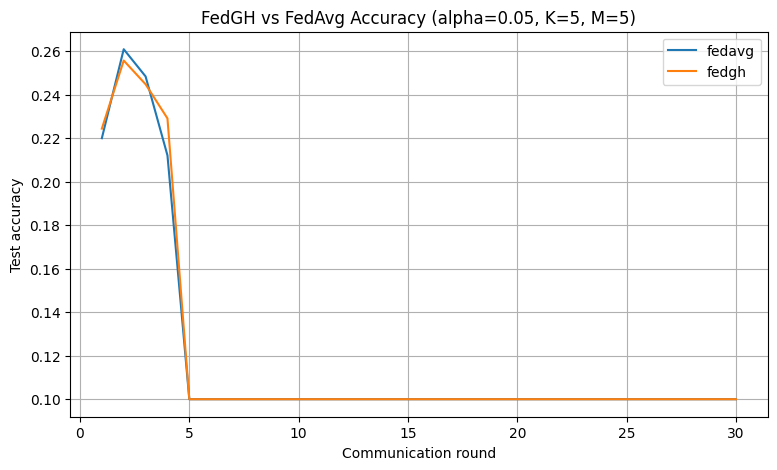

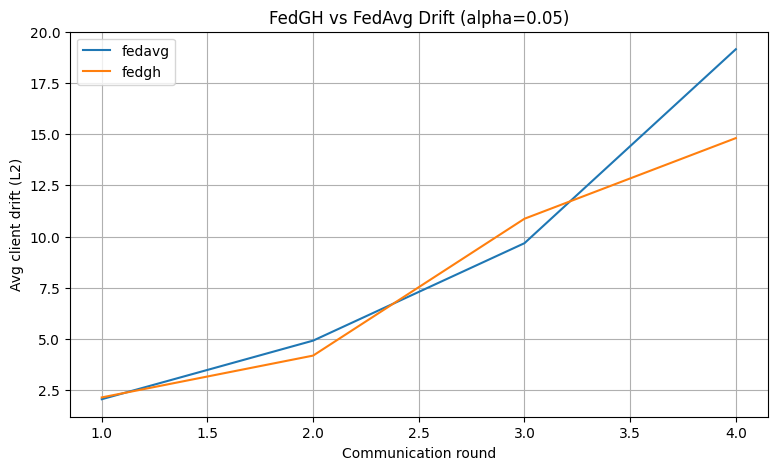

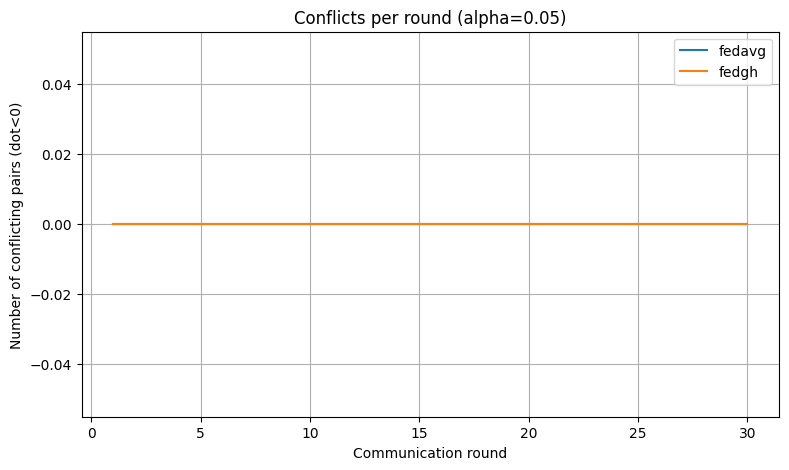

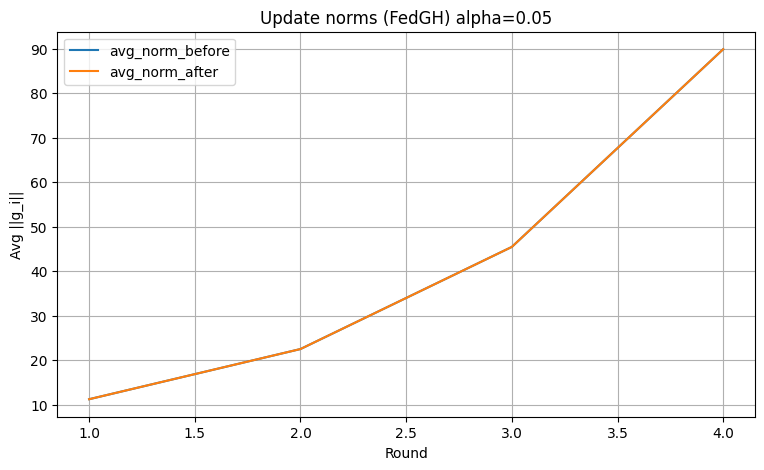

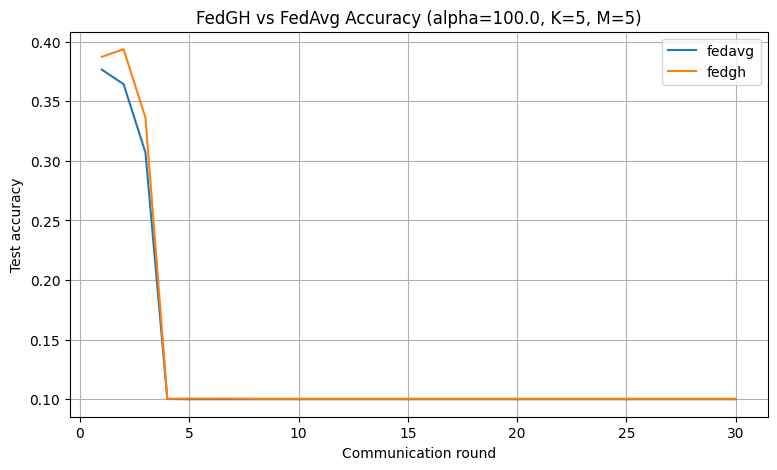

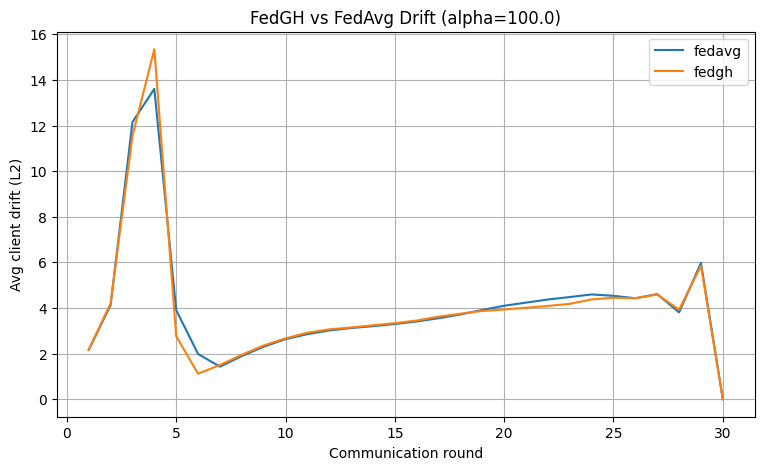

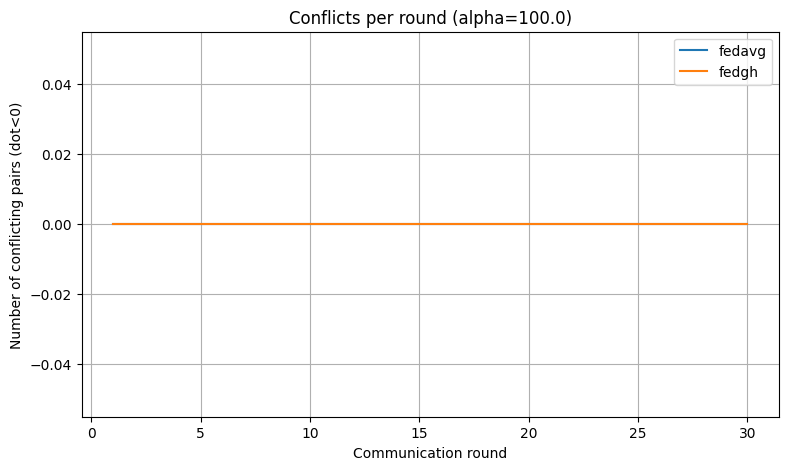

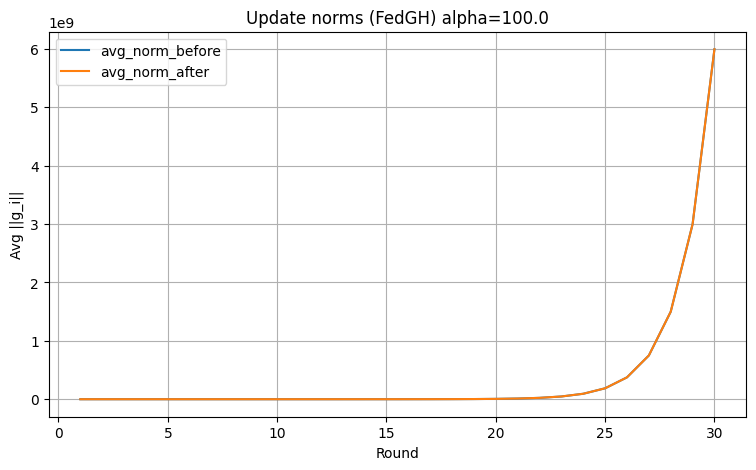


Summary (final accuracy, avg drift last5, avg conflicts last5):
alpha	method	final_acc	avg_drift_last5	avg_conflicts_last5
0.05	fedavg	0.1000	nan	0.00
0.05	fedgh	0.1000	nan	0.00
100.0	fedavg	0.1000	3.7641e+00	0.00
100.0	fedgh	0.1004	3.7592e+00	0.00

Saved plots to fedgh_results/


In [ ]:
# Colab-ready: FedGH (Gradient Harmonization) vs FedAvg comparison
!pip -q install torch torchvision --upgrade

import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import numpy as np, random, copy, math, os
import matplotlib.pyplot as plt
from tqdm import trange

# ===========================
# CONFIG
# ===========================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 12345
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

# Data / clients
M = 5                    # number of clients (small M is fine for FedGH)
total_samples = 5000     # subset of CIFAR-10 for speed
ALPHAS = [0.05, 100.0]   # highly skewed vs near-IID

# Training
K = 5                    # local epochs
ROUNDS = 30              # communication rounds
LOCAL_BS = 64
LR = 0.01
MOMENTUM = 0.9

# Methods to compare
METHODS = ['fedavg', 'fedgh']

SAVE_DIR = "fedgh_results"
os.makedirs(SAVE_DIR, exist_ok=True)

print("Device:", DEVICE)

# ===========================
# DATA & MODEL
# ===========================
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261)),
])

full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# use a shuffled subset for speed
all_indices = list(range(len(full_train)))
random.shuffle(all_indices)
subset_indices = all_indices[:total_samples]
subset_labels = [full_train[i][1] for i in subset_indices]

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*16*16,256)
        self.fc2 = nn.Linear(256,num_classes)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ===========================
# HELPERS: Dirichlet partition, eval, params
# ===========================
def dirichlet_partition(labels, M, alpha, seed=None):
    if seed is not None:
        np.random.seed(seed); random.seed(seed)
    labels = np.array(labels)
    client_indices = [[] for _ in range(M)]
    C = labels.max() + 1
    for c in range(C):
        idx_c = np.where(labels == c)[0].tolist()
        if len(idx_c) == 0:
            continue
        np.random.shuffle(idx_c)
        props = np.random.dirichlet([alpha]*M)
        counts = np.random.multinomial(len(idx_c), props)
        cur = 0
        for j in range(M):
            cnt = counts[j]
            if cnt>0:
                client_indices[j].extend(idx_c[cur:cur+cnt])
            cur += cnt
    client_abs = [[subset_indices[i] for i in idx_list] for idx_list in client_indices]
    return client_abs

def build_client_datasets(client_abs_indices):
    return [Subset(full_train, idxs) for idxs in client_abs_indices]

def evaluate(model, loader, device):
    model.eval()
    total=0; correct=0; loss_sum=0.0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss_sum += float(criterion(out,yb).item())
            preds = out.argmax(dim=1)
            correct += int((preds==yb).sum().item())
            total += yb.size(0)
    return loss_sum/total, correct/total

def get_param_tensors(model):
    return [p.data.clone().cpu() for p in model.parameters()]

def set_param_tensors(model, tensors):
    for p,t in zip(model.parameters(), tensors):
        p.data.copy_(t.to(p.device))

def param_l2_norm_diff(paramsA, paramsB):
    s = 0.0
    for a,b in zip(paramsA, paramsB):
        diff = (a - b).view(-1)
        s += float((diff*diff).sum().cpu())
    return math.sqrt(s)

# ===========================
# FL local steps (FedAvg)
# ===========================
def local_train_fedavg(client_model, loader, K, optimizer, device):
    client_model.train()
    for epoch in range(K):
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = client_model(xb)
            loss = F.cross_entropy(out,yb)
            loss.backward()
            optimizer.step()
    return get_param_tensors(client_model)

# ===========================
# FedGH: flatten/unflatten utilities & harmonization
# ===========================
def flatten_params(param_list):
    """Given list-of-tensors (CPU), return single 1D flat tensor and a shapes-slices mapping"""
    flats = []
    shapes = []
    for p in param_list:
        shapes.append(p.size())
        flats.append(p.view(-1))
    if len(flats)==0:
        return torch.tensor([], dtype=torch.float32), shapes
    return torch.cat(flats), shapes

def unflatten_to_param_list(flat, shapes, device=None):
    """Given flat tensor and shapes list, return list of tensors shaped accordingly"""
    params = []
    cur = 0
    for s in shapes:
        n = 1
        for d in s:
            n *= d
        chunk = flat[cur:cur+n]
        params.append(chunk.view(s).to(device) if device is not None else chunk.view(s))
        cur += n
    return params

def harmonize_updates(update_list_cpu, eps=1e-12):
    """
    update_list_cpu: list of 1D CPU tensors (flattened gi = theta_i - theta_global)
    Returns harmonized list of same shape, count_conflicts
    Implementation: single pass over unordered pairs, compute projections using originals,
    apply symmetric removal on working copies.
    """
    Mloc = len(update_list_cpu)
    if Mloc == 0:
        return update_list_cpu, 0
    # originals and working copies
    G_orig = [g.clone() for g in update_list_cpu]
    G_mod = [g.clone() for g in update_list_cpu]
    conflict_count = 0
    for i in range(Mloc):
        for j in range(i+1, Mloc):
            gi = G_orig[i]
            gj = G_orig[j]
            dot = float(gi.dot(gj))
            if dot < 0.0:
                conflict_count += 1
                denom_j = float(gj.dot(gj)) + eps
                denom_i = float(gi.dot(gi)) + eps
                proj_i_on_j = dot / denom_j
                proj_j_on_i = dot / denom_i
                # apply symmetric removal using originals
                G_mod[i] = G_mod[i] - proj_i_on_j * gj
                G_mod[j] = G_mod[j] - proj_j_on_i * gi
    return G_mod, conflict_count

# ===========================
# Runner: FedAvg and FedGH
# ===========================
def run_fedgh_vs_fedavg(alpha, rounds=ROUNDS, K=K, local_bs=LOCAL_BS, lr=LR, momentum=MOMENTUM, device=DEVICE, seed=SEED):
    client_abs = dirichlet_partition(np.array(subset_labels), M=M, alpha=alpha, seed=seed)
    client_sizes = [len(x) for x in client_abs]
    print(f"Alpha={alpha} client sizes: {client_sizes}")
    client_datasets = build_client_datasets(client_abs)
    client_loaders = [DataLoader(ds, batch_size=local_bs, shuffle=True) for ds in client_datasets]
    test_loader = DataLoader(test_set, batch_size=1000, shuffle=False)

    base_model = SmallCNN().to(device)
    init_state = copy.deepcopy(base_model.state_dict())

    results = {m: {'accs': [], 'drift': [], 'conflicts': [], 'avg_norm_before': [], 'avg_norm_after': []} for m in METHODS}

    for method in METHODS:
        print(f"\n=== Running method: {method} ===")
        global_model = SmallCNN().to(device)
        global_model.load_state_dict(init_state)

        client_models = [SmallCNN().to(device) for _ in range(M)]
        for cm in client_models:
            cm.load_state_dict(init_state)

        for r in range(rounds):
            global_before = get_param_tensors(global_model)  # CPU snapshot
            client_params_after = []
            client_N = []

            # Local training
            for i in range(M):
                client_models[i].load_state_dict(global_model.state_dict())
                optimizer = optim.SGD(client_models[i].parameters(), lr=lr, momentum=momentum)
                if len(client_loaders[i].dataset) == 0:
                    client_params_after.append(get_param_tensors(client_models[i]))
                    client_N.append(0)
                    continue
                params_after = local_train_fedavg(client_models[i], client_loaders[i], K, optimizer, device)
                client_params_after.append(params_after)
                client_N.append(len(client_loaders[i].dataset))

            # compute drift
            valid = [(p,s) for p,s in zip(client_params_after, client_N) if s>0]
            if len(valid)==0:
                avg_drift = 0.0
            else:
                drift_sum = 0.0
                for p,s in valid:
                    drift_sum += param_l2_norm_diff(p, global_before)
                avg_drift = drift_sum / len(valid)
            results[method]['drift'].append(avg_drift)

            # Prepare updates gi = theta_i - theta_global (flattened on CPU)
            updates_cpu = []
            shapes = None
            norms_before = []
            for params in client_params_after:
                flat, shapes = flatten_params(params)  # params are CPU tensors already
                updates_cpu.append(flat)
                norms_before.append(float(flat.norm().item()))
            avg_norm_before = float(np.mean(norms_before)) if norms_before else 0.0
            results[method]['avg_norm_before'].append(avg_norm_before)

            # If FedGH, harmonize updates_cpu
            if method == 'fedgh':
                G_mod, conflict_count = harmonize_updates(updates_cpu)
                updates_final = G_mod
                results[method]['conflicts'].append(conflict_count)
                norms_after = [float(g.norm().item()) for g in updates_final]
                results[method]['avg_norm_after'].append(float(np.mean(norms_after)) if norms_after else 0.0)
            else:
                # FedAvg: no harmonization
                updates_final = updates_cpu
                results[method]['conflicts'].append(0)
                results[method]['avg_norm_after'].append(results[method]['avg_norm_before'][-1])

            # Reconstruct updated global by averaging flattened updates (weighted)
            totalN = sum(client_N) if sum(client_N)>0 else 1
            weighted_sum = torch.zeros_like(updates_final[0])
            for upd, Ni in zip(updates_final, client_N):
                w = (Ni/totalN) if Ni>0 else 0.0
                weighted_sum += w * upd
            # weighted_sum is the average delta; apply: theta_new = theta_global + weighted_sum (unflattened)
            new_params = unflatten_to_param_list(weighted_sum, shapes, device)  # list of tensors on device
            # set global model params (note: new_params are deltas)
            # Reconstruct global as theta_global + delta
            new_global = []
            for g_before, delta in zip(global_before, new_params):
                new_global.append((g_before.to(delta.device) + delta).to(g_before.device))
            # new_global is list of tensors on CPU; set global model
            set_param_tensors(global_model, new_global)

            # Evaluate
            g_loss, g_acc = evaluate(global_model, test_loader, device)
            results[method]['accs'].append(g_acc)

            if (r % max(1, rounds//10) == 0) or r == rounds-1:
                print(f" Round {r+1}/{rounds} | method={method} | drift={avg_drift:.4e} | conflicts={results[method]['conflicts'][-1]} | test_acc={g_acc:.4f}")

    return results

# ===========================
# RUN experiments for ALPHAS
# ===========================
all_results = {}
for alpha in ALPHAS:
    print("\n" + "="*60)
    print(f"Starting alpha = {alpha}")
    res = run_fedgh_vs_fedavg(alpha, rounds=ROUNDS, K=K, local_bs=LOCAL_BS, lr=LR, momentum=MOMENTUM, device=DEVICE, seed=SEED)
    all_results[alpha] = res

# ===========================
# PLOT & SUMMARY
# ===========================
for alpha, resdict in all_results.items():
    # Accuracy
    plt.figure(figsize=(9,5))
    for method, v in resdict.items():
        x = np.arange(1, ROUNDS+1)
        y = v['accs']
        plt.plot(x, y, label=f"{method}")
    plt.xlabel("Communication round")
    plt.ylabel("Test accuracy")
    plt.title(f"FedGH vs FedAvg Accuracy (alpha={alpha}, K={K}, M={M})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"accuracy_alpha_{alpha}.png"))
    plt.show()

    # Drift
    plt.figure(figsize=(9,5))
    for method, v in resdict.items():
        x = np.arange(1, ROUNDS+1)
        y = v['drift']
        plt.plot(x, y, label=f"{method}")
    plt.xlabel("Communication round")
    plt.ylabel("Avg client drift (L2)")
    plt.title(f"FedGH vs FedAvg Drift (alpha={alpha})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"drift_alpha_{alpha}.png"))
    plt.show()

    # Conflicts
    plt.figure(figsize=(9,5))
    for method, v in resdict.items():
        x = np.arange(1, ROUNDS+1)
        y = v['conflicts']
        plt.plot(x, y, label=f"{method}")
    plt.xlabel("Communication round")
    plt.ylabel("Number of conflicting pairs (dot<0)")
    plt.title(f"Conflicts per round (alpha={alpha})")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(SAVE_DIR, f"conflicts_alpha_{alpha}.png"))
    plt.show()

    # Norms before/after (only for FedGH meaningful)
    if 'fedgh' in resdict:
        plt.figure(figsize=(9,5))
        plt.plot(np.arange(1,ROUNDS+1), resdict['fedgh']['avg_norm_before'], label='avg_norm_before')
        plt.plot(np.arange(1,ROUNDS+1), resdict['fedgh']['avg_norm_after'], label='avg_norm_after')
        plt.xlabel("Round"); plt.ylabel("Avg ||g_i||")
        plt.title(f"Update norms (FedGH) alpha={alpha}")
        plt.legend(); plt.grid(True)
        plt.savefig(os.path.join(SAVE_DIR, f"norms_alpha_{alpha}.png"))
        plt.show()

# Summary table
print("\nSummary (final accuracy, avg drift last5, avg conflicts last5):")
print("alpha\tmethod\tfinal_acc\tavg_drift_last5\tavg_conflicts_last5")
for alpha, resdict in all_results.items():
    for method, v in resdict.items():
        final_acc = v['accs'][-1]
        avg_drift_last5 = np.mean(v['drift'][-5:]) if len(v['drift'])>=5 else np.mean(v['drift'])
        avg_conf_last5 = np.mean(v['conflicts'][-5:]) if len(v['conflicts'])>=5 else np.mean(v['conflicts'])
        print(f"{alpha}\t{method}\t{final_acc:.4f}\t{avg_drift_last5:.4e}\t{avg_conf_last5:.2f}")

print(f"\nSaved plots to {SAVE_DIR}/")


##Task 4.4